# Implementing PID Controllers with Python Yield Statement

Up to this point we have been implementing simple control strategies where the manipulated variable depends only on current values of the process variable and setpoint. Relay control, for example, can be expressed mathematically as

$$MV = Kp (SP - PV)$$

and implemented in Python as

    def proportional(PV, SP):
        MV = Kp * (SP - PV)
        return MV

Python functions carry no persistent memory from one use to the next, which is fine if the control algorithm requires no knowledge of the past.

The problem, however, is that PID control requires use of past measurements. Proportional-integral control, for example, tracks the cumulative sum of the differences between setpoint and the process variable. Because a Python function disappears completely after the return statement, the value of the cumulative sum must be stored somewhere else in code. The coding problem is to figure out how and where to store that information between calls to the algorithm. We seek coding methods that encapsulate the state of control algorithms.

There are several ways persistence can be provided in Python (roughly in order of increasing capability and complexity):

* Generators written using the Python `yield` statement
* Classes
* Asynchronous programming with co-routines
* Threads

Classes, in particular, are a tool for encapsulating data and functionality within a single software entity. Classes are widely used in Python programming, and should eventually become part of every Python programmer's toolkit.

As we demonstrate below, however, the Python `yield` statement is often sufficient to write self-contained implementations of control algorithm. 

## Python Yield Statement

The cells below provide a very brief introduction to Python `yield` statement. More information can be found [here](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/)

A function incorporating a `yield` statement creates a persistent object called a generator.  Like the `return` statement, `yield` says to return a value and control to the calling routine. Unlike the `return` statement, however, the generator goes into a suspended state following the `yield`. On the next use it will pick up execution right where execution left off.

Here's an example produces a generator for four numbers.

In [12]:
def numbers_gen():
    yield 0
    yield 1
    yield 2.7182818
    yield 3.1415926

To use this, first create the actual generator object that will do the work. 

In [13]:
numbers = numbers_gen()

There are several ways to get values from a generator. One way is using the `next()` function which executes generator until the next `yield` statement is encountered, then return the value.

In [14]:
print(next(numbers))
print(next(numbers))
print(next(numbers))
print(next(numbers))

0
1
2.7182818
3.1415926


The generator object `numbers` has a `send` method for sending information to the generator and causing it to execute until the next `yield`.  For this case all we need to send is `None`.

In [15]:
numbers = numbers_gen()
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))

0
1
2.7182818
3.1415926


The `send` method provides two-way communication with a generator. Here's an example of how that works.

In [16]:
def texter_gen():
    a = yield "Started"
    b = yield a
    yield b

In [17]:
texter = texter_gen()
print(texter.send(None))
print(texter.send("Hello, World"))
print(texter.send("Go Irish"))

Started
Hello, World
Go Irish


There's a subtle detail here that easy to miss. The first `send` starts the generator which then executes up to the first yield statement. At that point execution halts and the message "Started" is sent to the calling routine. The second `send` causes execution to pick up again and puts the message "Hello, World" into variable `a`.  

An important point is that the first `send` to a generator must always be `None`.

In the next example `yield` is placed inside an infinite loop. This function creates generators that return the square of the number sent.

In [18]:
# A function that will create generators
def our_numbers():
    n = 0
    while True:
        n = yield n*n

In [19]:
# create a generator
numbers = our_numbers()

# start the generator
numbers.send(None)        

# send values to the generator and print the results
print(numbers.send(4))
print(numbers.send(12))
print(numbers.send(42))

# how to remove a generator when finished using it.
numbers.close()

16
144
1764


Let's now consider how generators may be used for process control applications. The next cell defines a function that will create generators that perform as proportional controllers with specified gain $K_p$ and setpoint $SP$. When sent a current value of the process variable `PV`, the controllers will return a value for the manipulated variable `MV`.

In [20]:
def proportional(Kp, SP):
    """Creates proportional controllers with specified gain and setpoint."""
    MV = 0
    while True:
        PV = yield MV
        MV = Kp * (SP - PV)

Let's create and initialize two controllers with the same setpoint but different gains.

In [21]:
controller1 = proportional(10, 40)
controller1.send(None)

controller2 = proportional(1, 40)
controller2.send(None)

0

Let's see how these controllers would respond to a PV value of 35.

In [22]:
PV = 35

print("Controller 1: MV = ", controller1.send(PV))
print("Controller 2: MV = ", controller2.send(PV))

Controller 1: MV =  50
Controller 2: MV =  5


This is a important feature from a coding and maintenance perspective. We need to create and maintain only one copy of the control algorithm.

## PID Control Implementation

A simple form of Proportional-Integral control is an example of a controller with internal state. In velocity form,

\begin{align}
MV_k & = \overline{MV} + K_P e_k  + K_I \sum_{k'=0}^k e_{k'}(t_k - t_{k-1}) + K_D \frac{e_k - e_{k-1}}{t_k - t_{k-1}}
\end{align}

where $e_k$ is the difference between setpoint and measured process variable

\begin{align}
e_k = SP_k - PV_k
\end{align}

$K_P$, $K_I$, and $K_D$ are control constants, and $t_k$ is the sampling time. 

The following cell provides a direct implementation of this algorithm as a Python generator.

In [23]:
def PID(Kp, Ki, Kd, MV_bar=0):
    # initialize stored data
    e_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, PV, SP
        t, PV, SP = yield MV
        
        # PID calculations
        e = SP - PV
        
        P = Kp*e
        I = I + Ki*e*(t - t_prev)
        D = Kd*(e - e_prev)/(t - t_prev)
        
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        e_prev = e
        t_prev = t

## Simulation

Let's see how well this PID implementation works. We'll perform the simulation with a setpoint that starts at room temperature, then rises to 50°C at $t = 50$ seconds. The data historian will record values of the setpoint, process variable, computed manipulated variable, and the actual value of the manipulated variable.

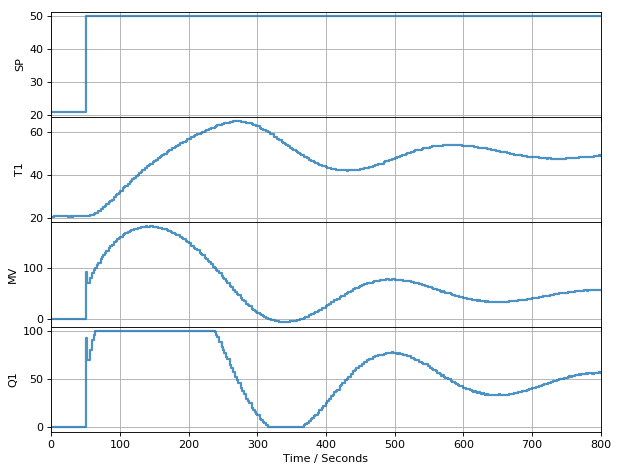

TCLab Model disconnected successfully.


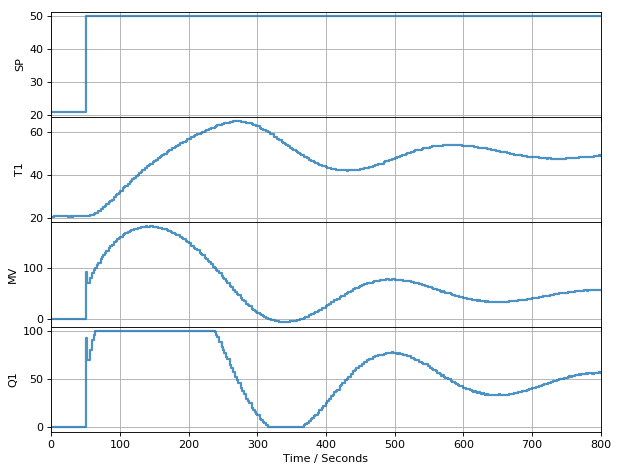

In [24]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2)        # create pid control
controller.send(None)              # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)                         # update information display

## Analysis

The good news is that the controller did steer the heater to the desired setpoint. There was some overshoot and undershoot along the way, but eventually the system did get there.

In examining the response more closely, however, we can see at least two issues that must be addressed before this control algorithm could be applied to large scale indusrial control:

1. A sudden adn abrubt "kick" to the manipulated variable when the setpoint changes.
2. A mismatch between computed and actually feasible control actions.